In [1]:
from tensorflow import keras
from keras.layers import Dense, Dropout,Flatten,Conv2D, MaxPooling2D
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import datetime
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt 

In [2]:
import sys
from os.path import join
exe_path = os.getcwd()

if 'projet_sudoku' in exe_path:
    exe_path = exe_path.split('projet_sudoku')[0]
if 'PROJETS' not in exe_path:
    exe_path = join(exe_path, "PROJETS")
if 'projet_sudoku' not in exe_path:
    exe_path = join(exe_path, "projet_sudoku")

print(f"[sudoku_extractor] execution path= {exe_path}")
sys.path.append(exe_path)
from sudoku_util import draw_digits, displayImages, preProcess

[sudoku_extractor] execution path= c:\Users\User\WORK\workspace-ia\PROJETS\projet_sudoku
[sudoku_util] execution path= c:\Users\User\WORK\workspace-ia\PROJETS\projet_sudoku


- Première version du modèle (celui d'origine) : 
  - data
  - score `[0.09560658782720566, 0.9682080745697021]`
- Seconde version du modèle : 
  - Ajout de d'image lié aux polices + des boxes de sudoku
  - 9539 images dont 7631 pour le train
  - loss: 0.0654 - accuracy: 0.9800 - val_loss: 0.1068 - val_accuracy: 0.9706
  - score `[0.10683777928352356, 0.9706498980522156]`
- 3ème version du modèle :
  - Ajout des boxes de sudoku récupéré via la caméra
  - 10187 images dont 8149 pour le train
  - score : `[0.1491367071866989, 0.9587831497192383]`
  - `{0: 1173, 1: 1149, 2: 1171, 3: 969, 4: 993, 5: 961, 6: 908, 7: 1043, 8: 889, 9: 931}`
- 4ème version du modèle :
  - Ajout des boxes de sudoku récupéré via la caméra
  - 10523 images dont 8418 pour le train
  - score : `[0.16389647126197815, 0.9586698412895203]`
  - `{0: 1173, 1: 1187, 2: 1213, 3: 1014, 4: 1034, 5: 1001, 6: 945, 7: 1070, 8: 922, 9: 964}`
- 5ème version du modèle :
  - preprocess des images : GaussianBlur + adaptiveThreshold
  - score : `[0.15173155069351196, 0.9653206467628479]`
- 6ème version du modèle :
  - preprocess des images : fastNlMeansDenoising + remplacement des valeurs < 200 par 0 et >200 par 255 => score : `[1.2580463886260986, 0.5705463290214539]`
  - preprocess des images : fastNlMeansDenoising => score : `[0.1759190857410431, 0.9539192318916321]`


In [3]:
verbose = 1
model_name = "aurao-V6"

In [4]:
X = []
y = []
heightImg = 28
widhtImg = 28

for i in range(0, 10):
    for d in os.listdir("../dataset/digits/{}".format(i)):
        # Lecture des images en noir et blanc directement
        # Même Preprocess des images que lors de l'utilisation du modèle
        t_img = preProcess(img_path="../dataset/digits/{}".format(i)+"/"+d, size= (heightImg,widhtImg), verbose=verbose-1)
        X.append(t_img)
        y.append(i)

In [5]:
X = np.array(X)
y = np.array(y)

In [6]:
from collections import Counter
count_ = Counter(y)
count_

Counter({0: 1173,
         1: 1187,
         2: 1213,
         3: 1014,
         4: 1034,
         5: 1001,
         6: 945,
         7: 1070,
         8: 922,
         9: 964})

In [7]:
print(X.shape)
y.shape

(10523, 28, 28)


(10523,)

In [8]:
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state= 21)

In [9]:
X_train.shape

(8418, 28, 28)

In [10]:
y_test

array([0, 3, 1, ..., 2, 7, 8])

In [11]:
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1)).astype('float32')
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
num_classes = y_test.shape[1]

In [12]:
num_classes

10

In [13]:
def larger_model():
    # create model
	model = keras.Sequential(
    [
        Conv2D(30, (5, 5), input_shape=(28, 28, 1), activation='relu'),
        MaxPooling2D(),
        Conv2D(15, (3, 3), activation='relu'),
        MaxPooling2D(),
        Dropout(0.2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(50, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    

    # Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model


In [14]:
model = larger_model()
log_dir = r"C:/Users/User/WORK/workspace-ia/PROJETS/projet_sudoku/model/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [15]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=10,callbacks=[tensorboard_callback])
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)

print("Large CNN Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/10
842/842 [==============================] - 8s 9ms/step - loss: 1.2064 - accuracy: 0.5854 - val_loss: 0.5619 - val_accuracy: 0.8285
Epoch 2/10
842/842 [==============================] - 7s 9ms/step - loss: 0.4970 - accuracy: 0.8401 - val_loss: 0.3926 - val_accuracy: 0.8903
Epoch 3/10
842/842 [==============================] - 6s 7ms/step - loss: 0.3344 - accuracy: 0.8947 - val_loss: 0.2589 - val_accuracy: 0.9302
Epoch 4/10
842/842 [==============================] - 5s 6ms/step - loss: 0.2495 - accuracy: 0.9186 - val_loss: 0.2527 - val_accuracy: 0.9245
Epoch 5/10
842/842 [==============================] - 5s 5ms/step - loss: 0.1937 - accuracy: 0.9357 - val_loss: 0.2253 - val_accuracy: 0.9392
Epoch 6/10
842/842 [==============================] - 5s 5ms/step - loss: 0.1592 - accuracy: 0.9488 - val_loss: 0.2047 - val_accuracy: 0.9435
Epoch 7/10
842/842 [==============================] - 5s 6ms/step - loss: 0.1341 - accuracy: 0.9540 - val_loss: 0.2182 - val_accuracy: 0.9406
Epoch 

In [16]:
# V1 : [0.09560658782720566, 0.9682080745697021]
# V2 : [0.10683777928352356, 0.9706498980522156]
# V3 : [0.1491367071866989, 0.9587831497192383]
# V4 : [0.16389647126197815, 0.9586698412895203]
# V5 : [0.15173155069351196, 0.9653206467628479]
# V6 : [0.1759190857410431, 0.9539192318916321]
scores

[0.1759190857410431, 0.9539192318916321]

In [17]:
pred = model.predict(X_test,verbose = 1)
pred_classes = []

for p in pred:
    classIndex = np.argmax(p)
    probabilityValue = np.amax(p)
    
    if probabilityValue > 0.65:
        pred_classes.append(classIndex)
    else:
        pred_classes.append(0)

66/66 [==============================] - 0s 4ms/step


In [18]:
len(X_test)

2105

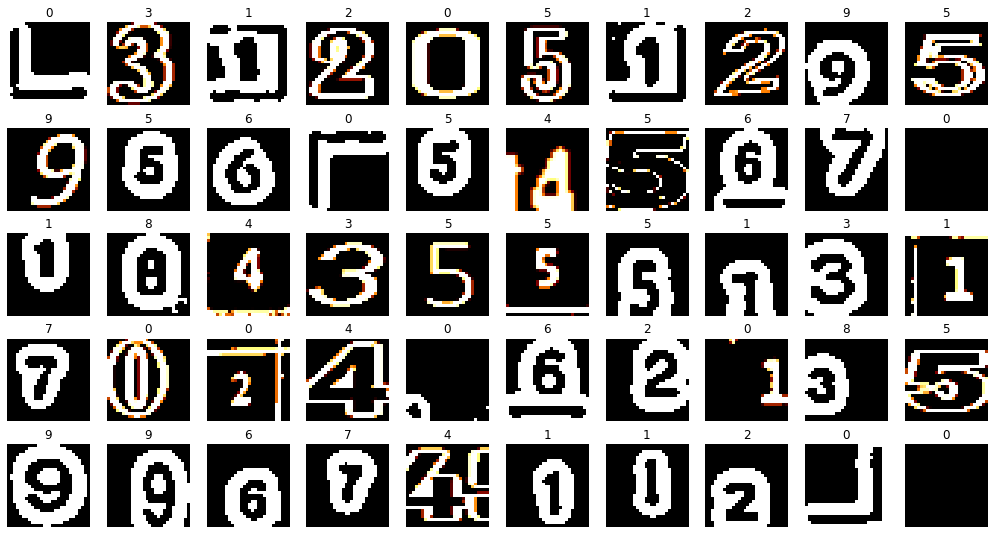

In [19]:
draw_digits(X=X_test, y=pred_classes, nb=50)

In [20]:
# Error pred
X_error = []
y_error_expected = []
y_error_pred = []

for idx in range(0, len(pred_classes)):
    expected = np.argmax(y_test[idx])
    if pred_classes[idx] != expected:
        X_error.append(X_test[idx])
        y_error_expected.append(expected)
        y_error_pred.append(f"{pred_classes[idx]} vs {expected}")
print(len(y_error_pred))

121


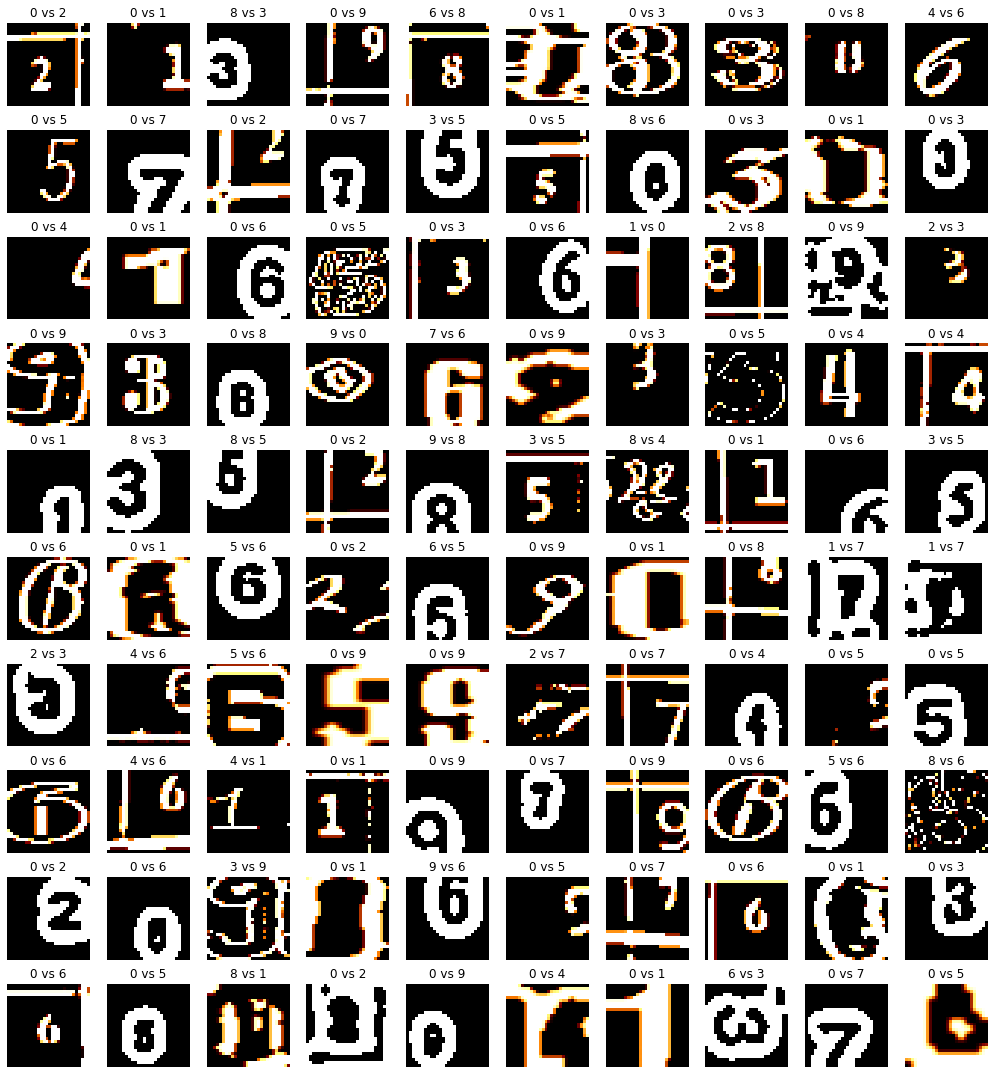

In [21]:
draw_digits(X=X_error, y=y_error_pred, nb=100)

In [26]:
mod_path = join(r"C:\Users\User\WORK\workspace-ia\PROJETS\projet_sudoku\model", model_name)
model.save(mod_path)

INFO:tensorflow:Assets written to: C:\Users\User\WORK\workspace-ia\PROJETS\projet_sudoku\model\aurao-V6\assets


INFO:tensorflow:Assets written to: C:\Users\User\WORK\workspace-ia\PROJETS\projet_sudoku\model\aurao-V6\assets


In [22]:
def add_preprocess(img):
    # cv2.fastNlMeansDenoising(src=img, dst=None, h=20, templateWindowSize=7, searchWindowSize=21) 
    cv2.fastNlMeansDenoising(img, None, 20, 7, 21) 
    # dst = cv2.fastNlMeansDenoising(img, 2, 5, None, 4, 7, 35)
    dst = cv2.fastNlMeansDenoising(img)
    # dst = cv2.fastNlMeansDenoisingMulti(img, 2, 5, None, 4, 7, 35)
    return dst

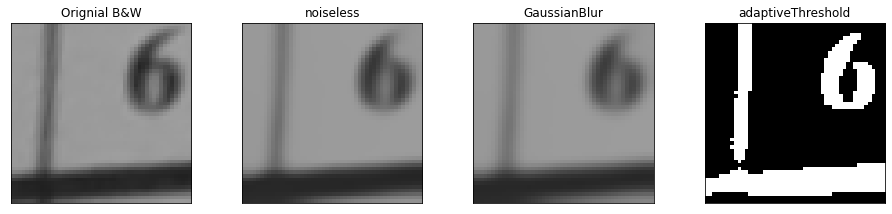

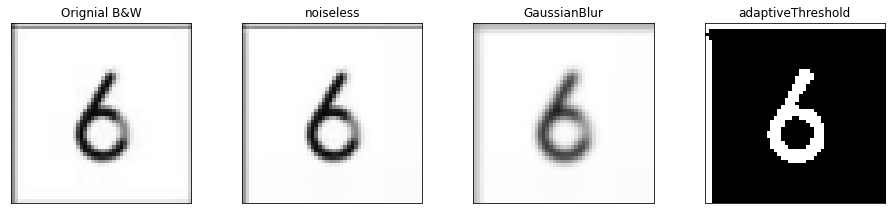

In [23]:
img_path = r'C:\Users\User\WORK\workspace-ia\PROJETS\projet_sudoku\dataset\digits\6\opencv_frame_2022-11-25-100006-12-24.png'
test = preProcess(img_path=img_path, size=(28,28), verbose=2)
img_path = r'C:\Users\User\WORK\workspace-ia\PROJETS\projet_sudoku\dataset\digits\6\sudoku-006-41.png'
test = preProcess(img_path=img_path, size=(28,28), less_limit=200, verbose=2)

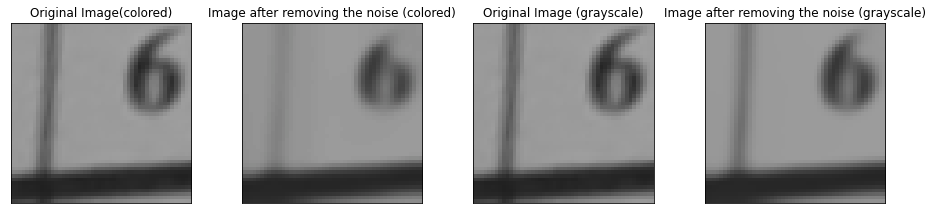

In [24]:

img_path = r'C:\Users\User\WORK\workspace-ia\PROJETS\projet_sudoku\dataset\digits\6\opencv_frame_2022-11-25-100006-12-24.png'
image = cv2.imread(img_path,1) 
image_bw = cv2.imread(img_path,0) 

noiseless_image_bw = cv2.fastNlMeansDenoising(image_bw, None, 20, 7, 21) 
noiseless_image_colored = cv2.fastNlMeansDenoisingColored(image,None,20,20,7,21) 

titles = ['Original Image(colored)','Image after removing the noise (colored)', 'Original Image (grayscale)','Image after removing the noise (grayscale)']
images = [image,noiseless_image_colored, image_bw, noiseless_image_bw]
plt.figure(figsize=(13,3))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [25]:
X_error_n_preprocess = []
for img in X_error:
    X_error_n_preprocess.append(add_preprocess(img=img))

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\photo\src\denoising.cpp:142: error: (-5:Bad argument) Unsupported depth! Only CV_8U is supported for NORM_L2 in function 'cv::fastNlMeansDenoising'


ValueError: cannot reshape array of size 28 into shape (28,28)

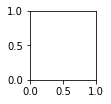

In [ ]:
draw_digits(X=X_error_n_preprocess, y=y_error_pred, nb=100)

In [ ]:
Just to fail

SyntaxError: invalid syntax (4107494479.py, line 1)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 34160), started 1 day, 19:53:34 ago. (Use '!kill 34160' to kill it.)